In [1]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sub_cond_path = '../subject_info.xlsx'
base_nifti_folder = '../data_FC'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [3]:
# Load and preprocess
use_roi = 0
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix',row_idx=use_roi)
# One-hot encode subject ID as condition
subject_arr = np.array(all_subject_id).reshape(-1, 1)
subject_encoder = OneHotEncoder(sparse_output=False, drop=None)
subject_ohe = subject_encoder.fit_transform(subject_arr)  # shape: [n_samples, n_subjects]

# Convert to torch tensors
X_tensor = preprocess_for_torch(all_corr_data)  
subject_cond_tensor = torch.tensor(subject_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor, subject_cond_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

[WARN] File not found: ../data_FC/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_88/D0/conn_matrix_w_sphere.mat
Columns with NaN: 14 / 116
Tensor shape after preprocessing: torch.Size([331, 102])


In [8]:
X_tensor.shape

torch.Size([331, 102])

In [9]:
subject_cond_tensor.shape

torch.Size([331, 48])

In [4]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
cond_dim = subject_cond_tensor.shape[1]
latent_dim = 10
hidden_dim = 64 
NUM_EPOCH = 500
LR = 3e-4
model = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 152.20it/s]


Epoch 1, Loss: 103.7873, Recon: 103.4471, KL: 0.3402

===== Epoch 2 =====


Epoch 2/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1016.82it/s]


Epoch 2, Loss: 103.3232, Recon: 103.0175, KL: 0.3057

===== Epoch 3 =====


Epoch 3/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1026.80it/s]


Epoch 3, Loss: 102.7042, Recon: 102.3509, KL: 0.3533

===== Epoch 4 =====


Epoch 4/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1114.83it/s]


Epoch 4, Loss: 102.1612, Recon: 101.6784, KL: 0.4828

===== Epoch 5 =====


Epoch 5/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1193.23it/s]


Epoch 5, Loss: 101.5298, Recon: 100.8427, KL: 0.6871

===== Epoch 6 =====


Epoch 6/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1166.88it/s]


Epoch 6, Loss: 100.3743, Recon: 99.3293, KL: 1.0450

===== Epoch 7 =====


Epoch 7/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 798.96it/s]


Epoch 7, Loss: 98.8751, Recon: 97.1966, KL: 1.6785

===== Epoch 8 =====


Epoch 8/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1171.71it/s]


Epoch 8, Loss: 96.6045, Recon: 93.9716, KL: 2.6329

===== Epoch 9 =====


Epoch 9/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1205.57it/s]


Epoch 9, Loss: 93.6640, Recon: 89.7378, KL: 3.9262

===== Epoch 10 =====


Epoch 10/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1117.88it/s]


Epoch 10, Loss: 90.9366, Recon: 85.6487, KL: 5.2879

===== Epoch 11 =====


Epoch 11/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 361.26it/s]


Epoch 11, Loss: 87.8712, Recon: 81.9835, KL: 5.8877

===== Epoch 12 =====


Epoch 12/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1020.99it/s]


Epoch 12, Loss: 85.2155, Recon: 79.4320, KL: 5.7835

===== Epoch 13 =====


Epoch 13/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1124.53it/s]


Epoch 13, Loss: 82.9778, Recon: 77.3630, KL: 5.6148

===== Epoch 14 =====


Epoch 14/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1121.66it/s]


Epoch 14, Loss: 81.6427, Recon: 75.9737, KL: 5.6690

===== Epoch 15 =====


Epoch 15/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1281.49it/s]


Epoch 15, Loss: 79.9204, Recon: 73.5152, KL: 6.4052

===== Epoch 16 =====


Epoch 16/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1229.90it/s]


Epoch 16, Loss: 77.9469, Recon: 71.2023, KL: 6.7447

===== Epoch 17 =====


Epoch 17/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1073.16it/s]


Epoch 17, Loss: 75.5798, Recon: 68.5608, KL: 7.0190

===== Epoch 18 =====


Epoch 18/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1154.99it/s]


Epoch 18, Loss: 74.1433, Recon: 66.7499, KL: 7.3934

===== Epoch 19 =====


Epoch 19/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1122.10it/s]


Epoch 19, Loss: 72.6749, Recon: 64.8941, KL: 7.7808

===== Epoch 20 =====


Epoch 20/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1211.46it/s]


Epoch 20, Loss: 71.3696, Recon: 63.5560, KL: 7.8136

===== Epoch 21 =====


Epoch 21/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 977.42it/s]


Epoch 21, Loss: 69.5082, Recon: 61.7113, KL: 7.7968

===== Epoch 22 =====


Epoch 22/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1041.05it/s]


Epoch 22, Loss: 68.5736, Recon: 60.8990, KL: 7.6746

===== Epoch 23 =====


Epoch 23/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1210.26it/s]


Epoch 23, Loss: 67.6883, Recon: 60.1869, KL: 7.5014

===== Epoch 24 =====


Epoch 24/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1152.45it/s]


Epoch 24, Loss: 66.4300, Recon: 59.0255, KL: 7.4045

===== Epoch 25 =====


Epoch 25/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1140.49it/s]


Epoch 25, Loss: 66.5238, Recon: 59.1116, KL: 7.4122

===== Epoch 26 =====


Epoch 26/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1199.81it/s]


Epoch 26, Loss: 65.6302, Recon: 57.9760, KL: 7.6541

===== Epoch 27 =====


Epoch 27/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1192.55it/s]


Epoch 27, Loss: 64.6441, Recon: 56.9260, KL: 7.7181

===== Epoch 28 =====


Epoch 28/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1149.04it/s]


Epoch 28, Loss: 64.0877, Recon: 56.5063, KL: 7.5814

===== Epoch 29 =====


Epoch 29/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1241.79it/s]


Epoch 29, Loss: 63.0759, Recon: 55.4340, KL: 7.6419

===== Epoch 30 =====


Epoch 30/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1208.64it/s]


Epoch 30, Loss: 62.5670, Recon: 54.6823, KL: 7.8847

===== Epoch 31 =====


Epoch 31/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1240.42it/s]


Epoch 31, Loss: 61.8452, Recon: 53.6695, KL: 8.1757

===== Epoch 32 =====


Epoch 32/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1239.15it/s]


Epoch 32, Loss: 61.5645, Recon: 53.4924, KL: 8.0721

===== Epoch 33 =====


Epoch 33/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1251.25it/s]


Epoch 33, Loss: 60.7518, Recon: 52.5104, KL: 8.2413

===== Epoch 34 =====


Epoch 34/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1243.33it/s]


Epoch 34, Loss: 59.4353, Recon: 51.0694, KL: 8.3659

===== Epoch 35 =====


Epoch 35/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1268.83it/s]


Epoch 35, Loss: 59.2513, Recon: 51.0262, KL: 8.2251

===== Epoch 36 =====


Epoch 36/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1245.34it/s]


Epoch 36, Loss: 58.2191, Recon: 49.8146, KL: 8.4045

===== Epoch 37 =====


Epoch 37/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1207.59it/s]


Epoch 37, Loss: 58.7316, Recon: 50.3492, KL: 8.3824

===== Epoch 38 =====


Epoch 38/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1228.76it/s]


Epoch 38, Loss: 57.9942, Recon: 49.6418, KL: 8.3524

===== Epoch 39 =====


Epoch 39/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1235.63it/s]


Epoch 39, Loss: 57.8709, Recon: 49.5898, KL: 8.2811

===== Epoch 40 =====


Epoch 40/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1189.66it/s]


Epoch 40, Loss: 56.7941, Recon: 48.4763, KL: 8.3178

===== Epoch 41 =====


Epoch 41/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1260.45it/s]


Epoch 41, Loss: 57.1762, Recon: 48.9628, KL: 8.2134

===== Epoch 42 =====


Epoch 42/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1334.76it/s]


Epoch 42, Loss: 56.9564, Recon: 48.7747, KL: 8.1817

===== Epoch 43 =====


Epoch 43/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1299.90it/s]


Epoch 43, Loss: 56.3191, Recon: 48.1085, KL: 8.2106

===== Epoch 44 =====


Epoch 44/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1320.36it/s]


Epoch 44, Loss: 55.5712, Recon: 47.3878, KL: 8.1834

===== Epoch 45 =====


Epoch 45/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1293.23it/s]


Epoch 45, Loss: 55.9350, Recon: 47.7607, KL: 8.1743

===== Epoch 46 =====


Epoch 46/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1280.28it/s]


Epoch 46, Loss: 55.6133, Recon: 47.4144, KL: 8.1988

===== Epoch 47 =====


Epoch 47/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1251.73it/s]


Epoch 47, Loss: 55.5901, Recon: 47.3882, KL: 8.2020

===== Epoch 48 =====


Epoch 48/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1287.89it/s]


Epoch 48, Loss: 55.0189, Recon: 46.7923, KL: 8.2266

===== Epoch 49 =====


Epoch 49/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1303.79it/s]


Epoch 49, Loss: 55.0360, Recon: 46.8145, KL: 8.2216

===== Epoch 50 =====


Epoch 50/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 978.83it/s]


Epoch 50, Loss: 54.3206, Recon: 46.1187, KL: 8.2019

===== Epoch 51 =====


Epoch 51/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1192.95it/s]


Epoch 51, Loss: 53.8913, Recon: 45.8294, KL: 8.0619

===== Epoch 52 =====


Epoch 52/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1283.23it/s]


Epoch 52, Loss: 54.3140, Recon: 46.3395, KL: 7.9744

===== Epoch 53 =====


Epoch 53/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1035.10it/s]


Epoch 53, Loss: 53.8364, Recon: 45.7036, KL: 8.1328

===== Epoch 54 =====


Epoch 54/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1275.78it/s]


Epoch 54, Loss: 54.1316, Recon: 45.9166, KL: 8.2150

===== Epoch 55 =====


Epoch 55/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1224.26it/s]


Epoch 55, Loss: 53.1839, Recon: 44.9231, KL: 8.2608

===== Epoch 56 =====


Epoch 56/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1299.90it/s]


Epoch 56, Loss: 53.2202, Recon: 45.0505, KL: 8.1696

===== Epoch 57 =====


Epoch 57/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1308.75it/s]


Epoch 57, Loss: 52.5948, Recon: 44.3293, KL: 8.2655

===== Epoch 58 =====


Epoch 58/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1125.08it/s]


Epoch 58, Loss: 52.6998, Recon: 44.4023, KL: 8.2975

===== Epoch 59 =====


Epoch 59/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1278.61it/s]


Epoch 59, Loss: 52.9519, Recon: 44.5778, KL: 8.3740

===== Epoch 60 =====


Epoch 60/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1282.80it/s]


Epoch 60, Loss: 52.2886, Recon: 43.7766, KL: 8.5120

===== Epoch 61 =====


Epoch 61/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1281.77it/s]


Epoch 61, Loss: 52.1847, Recon: 43.8495, KL: 8.3352

===== Epoch 62 =====


Epoch 62/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1313.59it/s]


Epoch 62, Loss: 51.7927, Recon: 43.3157, KL: 8.4770

===== Epoch 63 =====


Epoch 63/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1194.34it/s]


Epoch 63, Loss: 51.9599, Recon: 43.3412, KL: 8.6187

===== Epoch 64 =====


Epoch 64/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1223.02it/s]


Epoch 64, Loss: 51.5001, Recon: 42.8813, KL: 8.6189

===== Epoch 65 =====


Epoch 65/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1277.41it/s]


Epoch 65, Loss: 51.1080, Recon: 42.4826, KL: 8.6254

===== Epoch 66 =====


Epoch 66/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1123.82it/s]


Epoch 66, Loss: 50.8829, Recon: 42.2793, KL: 8.6036

===== Epoch 67 =====


Epoch 67/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1170.58it/s]


Epoch 67, Loss: 50.8363, Recon: 42.2450, KL: 8.5913

===== Epoch 68 =====


Epoch 68/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1245.64it/s]


Epoch 68, Loss: 50.7126, Recon: 42.2229, KL: 8.4896

===== Epoch 69 =====


Epoch 69/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1314.98it/s]


Epoch 69, Loss: 50.4007, Recon: 41.8597, KL: 8.5410

===== Epoch 70 =====


Epoch 70/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1261.20it/s]


Epoch 70, Loss: 50.3086, Recon: 41.6611, KL: 8.6474

===== Epoch 71 =====


Epoch 71/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1212.00it/s]


Epoch 71, Loss: 50.2063, Recon: 41.7426, KL: 8.4637

===== Epoch 72 =====


Epoch 72/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1256.57it/s]


Epoch 72, Loss: 50.1019, Recon: 41.7086, KL: 8.3933

===== Epoch 73 =====


Epoch 73/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1318.93it/s]


Epoch 73, Loss: 49.9036, Recon: 41.3509, KL: 8.5528

===== Epoch 74 =====


Epoch 74/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1331.53it/s]


Epoch 74, Loss: 49.9234, Recon: 41.3800, KL: 8.5435

===== Epoch 75 =====


Epoch 75/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1292.58it/s]


Epoch 75, Loss: 49.3645, Recon: 40.9011, KL: 8.4634

===== Epoch 76 =====


Epoch 76/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1314.83it/s]


Epoch 76, Loss: 49.6340, Recon: 41.1989, KL: 8.4351

===== Epoch 77 =====


Epoch 77/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1289.58it/s]


Epoch 77, Loss: 49.4633, Recon: 40.9513, KL: 8.5120

===== Epoch 78 =====


Epoch 78/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1332.06it/s]


Epoch 78, Loss: 49.3874, Recon: 40.6916, KL: 8.6958

===== Epoch 79 =====


Epoch 79/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1315.32it/s]


Epoch 79, Loss: 49.0470, Recon: 40.2897, KL: 8.7573

===== Epoch 80 =====


Epoch 80/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1301.04it/s]


Epoch 80, Loss: 48.8887, Recon: 40.2476, KL: 8.6411

===== Epoch 81 =====


Epoch 81/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1266.54it/s]


Epoch 81, Loss: 48.6670, Recon: 40.0680, KL: 8.5990

===== Epoch 82 =====


Epoch 82/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1296.83it/s]


Epoch 82, Loss: 48.6415, Recon: 39.9733, KL: 8.6682

===== Epoch 83 =====


Epoch 83/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1327.20it/s]


Epoch 83, Loss: 48.2693, Recon: 39.6875, KL: 8.5818

===== Epoch 84 =====


Epoch 84/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1313.89it/s]


Epoch 84, Loss: 48.2431, Recon: 39.6241, KL: 8.6190

===== Epoch 85 =====


Epoch 85/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1304.09it/s]


Epoch 85, Loss: 47.6680, Recon: 38.8497, KL: 8.8184

===== Epoch 86 =====


Epoch 86/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1294.76it/s]


Epoch 86, Loss: 47.8438, Recon: 39.1604, KL: 8.6834

===== Epoch 87 =====


Epoch 87/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1309.38it/s]


Epoch 87, Loss: 47.7618, Recon: 39.2063, KL: 8.5554

===== Epoch 88 =====


Epoch 88/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1269.29it/s]


Epoch 88, Loss: 47.8501, Recon: 39.2059, KL: 8.6442

===== Epoch 89 =====


Epoch 89/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1270.51it/s]


Epoch 89, Loss: 47.4351, Recon: 38.6417, KL: 8.7933

===== Epoch 90 =====


Epoch 90/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1014.12it/s]


Epoch 90, Loss: 47.2775, Recon: 38.4202, KL: 8.8573

===== Epoch 91 =====


Epoch 91/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1321.19it/s]


Epoch 91, Loss: 46.6992, Recon: 37.7761, KL: 8.9231

===== Epoch 92 =====


Epoch 92/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1258.18it/s]


Epoch 92, Loss: 46.4918, Recon: 37.6003, KL: 8.8916

===== Epoch 93 =====


Epoch 93/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1204.94it/s]


Epoch 93, Loss: 46.3447, Recon: 37.4763, KL: 8.8683

===== Epoch 94 =====


Epoch 94/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1125.19it/s]


Epoch 94, Loss: 46.4186, Recon: 37.4014, KL: 9.0172

===== Epoch 95 =====


Epoch 95/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1343.39it/s]


Epoch 95, Loss: 46.0880, Recon: 37.0621, KL: 9.0259

===== Epoch 96 =====


Epoch 96/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 753.05it/s]


Epoch 96, Loss: 46.1850, Recon: 37.1931, KL: 8.9918

===== Epoch 97 =====


Epoch 97/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1242.96it/s]


Epoch 97, Loss: 45.8131, Recon: 36.5864, KL: 9.2266

===== Epoch 98 =====


Epoch 98/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1224.39it/s]


Epoch 98, Loss: 45.6494, Recon: 36.4034, KL: 9.2461

===== Epoch 99 =====


Epoch 99/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1192.92it/s]


Epoch 99, Loss: 45.4190, Recon: 36.1691, KL: 9.2499

===== Epoch 100 =====


Epoch 100/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.25it/s]


Epoch 100, Loss: 45.2992, Recon: 36.1162, KL: 9.1831

===== Epoch 101 =====


Epoch 101/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1079.29it/s]


Epoch 101, Loss: 45.0447, Recon: 35.8513, KL: 9.1935

===== Epoch 102 =====


Epoch 102/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1135.10it/s]


Epoch 102, Loss: 44.9041, Recon: 35.7246, KL: 9.1794

===== Epoch 103 =====


Epoch 103/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1100.55it/s]


Epoch 103, Loss: 44.7349, Recon: 35.5228, KL: 9.2121

===== Epoch 104 =====


Epoch 104/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 798.97it/s]


Epoch 104, Loss: 44.8915, Recon: 35.6744, KL: 9.2171

===== Epoch 105 =====


Epoch 105/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 884.53it/s]


Epoch 105, Loss: 44.5511, Recon: 35.3034, KL: 9.2477

===== Epoch 106 =====


Epoch 106/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1079.08it/s]


Epoch 106, Loss: 44.1352, Recon: 34.8481, KL: 9.2871

===== Epoch 107 =====


Epoch 107/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 940.94it/s]


Epoch 107, Loss: 44.2130, Recon: 34.9538, KL: 9.2593

===== Epoch 108 =====


Epoch 108/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.13it/s]


Epoch 108, Loss: 44.2950, Recon: 34.9658, KL: 9.3293

===== Epoch 109 =====


Epoch 109/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1203.50it/s]


Epoch 109, Loss: 44.3808, Recon: 34.9155, KL: 9.4653

===== Epoch 110 =====


Epoch 110/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1157.78it/s]


Epoch 110, Loss: 43.7672, Recon: 34.3298, KL: 9.4374

===== Epoch 111 =====


Epoch 111/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1232.24it/s]


Epoch 111, Loss: 43.8939, Recon: 34.4349, KL: 9.4590

===== Epoch 112 =====


Epoch 112/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1230.26it/s]


Epoch 112, Loss: 43.1859, Recon: 33.8245, KL: 9.3615

===== Epoch 113 =====


Epoch 113/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.35it/s]


Epoch 113, Loss: 43.4919, Recon: 34.1810, KL: 9.3109

===== Epoch 114 =====


Epoch 114/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.05it/s]


Epoch 114, Loss: 43.3516, Recon: 34.0191, KL: 9.3325

===== Epoch 115 =====


Epoch 115/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.97it/s]


Epoch 115, Loss: 43.2705, Recon: 33.9204, KL: 9.3500

===== Epoch 116 =====


Epoch 116/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1215.04it/s]


Epoch 116, Loss: 42.8894, Recon: 33.5626, KL: 9.3268

===== Epoch 117 =====


Epoch 117/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1211.37it/s]


Epoch 117, Loss: 42.9650, Recon: 33.6264, KL: 9.3387

===== Epoch 118 =====


Epoch 118/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.00it/s]


Epoch 118, Loss: 42.6371, Recon: 33.1821, KL: 9.4550

===== Epoch 119 =====


Epoch 119/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1235.24it/s]


Epoch 119, Loss: 42.3044, Recon: 32.8914, KL: 9.4131

===== Epoch 120 =====


Epoch 120/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1103.98it/s]


Epoch 120, Loss: 42.5215, Recon: 33.2595, KL: 9.2620

===== Epoch 121 =====


Epoch 121/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.87it/s]


Epoch 121, Loss: 42.3789, Recon: 33.1044, KL: 9.2745

===== Epoch 122 =====


Epoch 122/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1154.36it/s]


Epoch 122, Loss: 42.4618, Recon: 33.0625, KL: 9.3993

===== Epoch 123 =====


Epoch 123/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1105.09it/s]


Epoch 123, Loss: 42.5201, Recon: 33.0112, KL: 9.5089

===== Epoch 124 =====


Epoch 124/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1018.71it/s]


Epoch 124, Loss: 41.6923, Recon: 32.1438, KL: 9.5485

===== Epoch 125 =====


Epoch 125/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1064.96it/s]


Epoch 125, Loss: 41.8828, Recon: 32.4549, KL: 9.4280

===== Epoch 126 =====


Epoch 126/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 858.56it/s]


Epoch 126, Loss: 41.9977, Recon: 32.5771, KL: 9.4206

===== Epoch 127 =====


Epoch 127/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1004.65it/s]


Epoch 127, Loss: 41.7936, Recon: 32.2649, KL: 9.5287

===== Epoch 128 =====


Epoch 128/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1204.32it/s]


Epoch 128, Loss: 41.9067, Recon: 32.2857, KL: 9.6211

===== Epoch 129 =====


Epoch 129/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1024.41it/s]


Epoch 129, Loss: 41.6522, Recon: 32.1068, KL: 9.5454

===== Epoch 130 =====


Epoch 130/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1189.32it/s]


Epoch 130, Loss: 41.6834, Recon: 32.0753, KL: 9.6081

===== Epoch 131 =====


Epoch 131/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1108.99it/s]


Epoch 131, Loss: 40.8553, Recon: 31.1274, KL: 9.7278

===== Epoch 132 =====


Epoch 132/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1269.92it/s]


Epoch 132, Loss: 41.0560, Recon: 31.5085, KL: 9.5476

===== Epoch 133 =====


Epoch 133/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1052.11it/s]


Epoch 133, Loss: 40.7818, Recon: 31.3470, KL: 9.4348

===== Epoch 134 =====


Epoch 134/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1254.69it/s]


Epoch 134, Loss: 40.8957, Recon: 31.3731, KL: 9.5226

===== Epoch 135 =====


Epoch 135/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.06it/s]


Epoch 135, Loss: 41.0112, Recon: 31.5026, KL: 9.5086

===== Epoch 136 =====


Epoch 136/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.75it/s]


Epoch 136, Loss: 40.9009, Recon: 31.4978, KL: 9.4032

===== Epoch 137 =====


Epoch 137/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.87it/s]


Epoch 137, Loss: 40.5952, Recon: 31.0624, KL: 9.5328

===== Epoch 138 =====


Epoch 138/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.61it/s]


Epoch 138, Loss: 40.5339, Recon: 30.9076, KL: 9.6262

===== Epoch 139 =====


Epoch 139/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.64it/s]


Epoch 139, Loss: 40.2828, Recon: 30.7346, KL: 9.5482

===== Epoch 140 =====


Epoch 140/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.00it/s]


Epoch 140, Loss: 40.4947, Recon: 31.0305, KL: 9.4643

===== Epoch 141 =====


Epoch 141/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.10it/s]


Epoch 141, Loss: 40.3409, Recon: 30.7580, KL: 9.5830

===== Epoch 142 =====


Epoch 142/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1326.89it/s]


Epoch 142, Loss: 40.3347, Recon: 30.7101, KL: 9.6247

===== Epoch 143 =====


Epoch 143/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.57it/s]


Epoch 143, Loss: 39.7911, Recon: 30.1544, KL: 9.6367

===== Epoch 144 =====


Epoch 144/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1159.35it/s]


Epoch 144, Loss: 39.8799, Recon: 30.3154, KL: 9.5645

===== Epoch 145 =====


Epoch 145/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.02it/s]


Epoch 145, Loss: 39.7180, Recon: 30.1967, KL: 9.5213

===== Epoch 146 =====


Epoch 146/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.59it/s]


Epoch 146, Loss: 39.6937, Recon: 30.2096, KL: 9.4842

===== Epoch 147 =====


Epoch 147/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.46it/s]


Epoch 147, Loss: 39.8508, Recon: 30.3317, KL: 9.5191

===== Epoch 148 =====


Epoch 148/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.39it/s]


Epoch 148, Loss: 39.9444, Recon: 30.3895, KL: 9.5549

===== Epoch 149 =====


Epoch 149/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1319.87it/s]


Epoch 149, Loss: 39.4748, Recon: 29.7933, KL: 9.6815

===== Epoch 150 =====


Epoch 150/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.24it/s]


Epoch 150, Loss: 39.1336, Recon: 29.4529, KL: 9.6807

===== Epoch 151 =====


Epoch 151/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.84it/s]


Epoch 151, Loss: 39.4715, Recon: 29.8917, KL: 9.5798

===== Epoch 152 =====


Epoch 152/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.77it/s]


Epoch 152, Loss: 39.2614, Recon: 29.6563, KL: 9.6050

===== Epoch 153 =====


Epoch 153/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1046.63it/s]


Epoch 153, Loss: 39.4387, Recon: 29.7286, KL: 9.7100

===== Epoch 154 =====


Epoch 154/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.49it/s]


Epoch 154, Loss: 39.2818, Recon: 29.4901, KL: 9.7916

===== Epoch 155 =====


Epoch 155/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.20it/s]


Epoch 155, Loss: 39.0128, Recon: 29.2590, KL: 9.7538

===== Epoch 156 =====


Epoch 156/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.42it/s]


Epoch 156, Loss: 38.6850, Recon: 29.0325, KL: 9.6524

===== Epoch 157 =====


Epoch 157/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.26it/s]


Epoch 157, Loss: 39.0988, Recon: 29.4193, KL: 9.6795

===== Epoch 158 =====


Epoch 158/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.77it/s]


Epoch 158, Loss: 38.9544, Recon: 29.2091, KL: 9.7454

===== Epoch 159 =====


Epoch 159/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.63it/s]


Epoch 159, Loss: 38.8015, Recon: 28.9842, KL: 9.8174

===== Epoch 160 =====


Epoch 160/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1289.44it/s]


Epoch 160, Loss: 38.5704, Recon: 28.7928, KL: 9.7776

===== Epoch 161 =====


Epoch 161/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.19it/s]


Epoch 161, Loss: 38.9269, Recon: 29.1289, KL: 9.7980

===== Epoch 162 =====


Epoch 162/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.80it/s]


Epoch 162, Loss: 38.6330, Recon: 28.7650, KL: 9.8680

===== Epoch 163 =====


Epoch 163/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.06it/s]


Epoch 163, Loss: 38.5307, Recon: 28.6580, KL: 9.8727

===== Epoch 164 =====


Epoch 164/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.71it/s]


Epoch 164, Loss: 38.0113, Recon: 28.1771, KL: 9.8342

===== Epoch 165 =====


Epoch 165/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.69it/s]


Epoch 165, Loss: 38.0841, Recon: 28.3620, KL: 9.7221

===== Epoch 166 =====


Epoch 166/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.68it/s]


Epoch 166, Loss: 38.0429, Recon: 28.3473, KL: 9.6956

===== Epoch 167 =====


Epoch 167/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.06it/s]


Epoch 167, Loss: 38.1804, Recon: 28.5329, KL: 9.6475

===== Epoch 168 =====


Epoch 168/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1215.52it/s]


Epoch 168, Loss: 37.9957, Recon: 28.2666, KL: 9.7290

===== Epoch 169 =====


Epoch 169/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1136.84it/s]


Epoch 169, Loss: 38.0440, Recon: 28.2980, KL: 9.7460

===== Epoch 170 =====


Epoch 170/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1189.97it/s]


Epoch 170, Loss: 38.2457, Recon: 28.5016, KL: 9.7441

===== Epoch 171 =====


Epoch 171/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1179.35it/s]


Epoch 171, Loss: 37.7580, Recon: 27.9278, KL: 9.8302

===== Epoch 172 =====


Epoch 172/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.22it/s]


Epoch 172, Loss: 37.9144, Recon: 28.0498, KL: 9.8645

===== Epoch 173 =====


Epoch 173/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1121.06it/s]


Epoch 173, Loss: 37.8603, Recon: 27.9673, KL: 9.8930

===== Epoch 174 =====


Epoch 174/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1009.55it/s]


Epoch 174, Loss: 37.5817, Recon: 27.6603, KL: 9.9214

===== Epoch 175 =====


Epoch 175/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.94it/s]


Epoch 175, Loss: 37.2806, Recon: 27.3601, KL: 9.9205

===== Epoch 176 =====


Epoch 176/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.29it/s]


Epoch 176, Loss: 37.3498, Recon: 27.5589, KL: 9.7908

===== Epoch 177 =====


Epoch 177/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.32it/s]


Epoch 177, Loss: 37.6015, Recon: 27.8430, KL: 9.7585

===== Epoch 178 =====


Epoch 178/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 842.38it/s]


Epoch 178, Loss: 37.3508, Recon: 27.5359, KL: 9.8149

===== Epoch 179 =====


Epoch 179/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1029.21it/s]


Epoch 179, Loss: 37.4246, Recon: 27.5590, KL: 9.8656

===== Epoch 180 =====


Epoch 180/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1009.26it/s]


Epoch 180, Loss: 36.9747, Recon: 27.1127, KL: 9.8620

===== Epoch 181 =====


Epoch 181/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1008.16it/s]


Epoch 181, Loss: 36.9362, Recon: 27.2413, KL: 9.6949

===== Epoch 182 =====


Epoch 182/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 987.09it/s]


Epoch 182, Loss: 36.8954, Recon: 27.1936, KL: 9.7018

===== Epoch 183 =====


Epoch 183/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1012.14it/s]


Epoch 183, Loss: 36.6990, Recon: 26.9903, KL: 9.7087

===== Epoch 184 =====


Epoch 184/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1001.18it/s]


Epoch 184, Loss: 37.0253, Recon: 27.3201, KL: 9.7052

===== Epoch 185 =====


Epoch 185/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 983.80it/s]


Epoch 185, Loss: 36.7291, Recon: 26.9932, KL: 9.7360

===== Epoch 186 =====


Epoch 186/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1030.91it/s]


Epoch 186, Loss: 36.8977, Recon: 27.1808, KL: 9.7169

===== Epoch 187 =====


Epoch 187/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1096.94it/s]


Epoch 187, Loss: 36.6722, Recon: 26.8586, KL: 9.8136

===== Epoch 188 =====


Epoch 188/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1048.41it/s]


Epoch 188, Loss: 36.8307, Recon: 26.9346, KL: 9.8961

===== Epoch 189 =====


Epoch 189/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 951.15it/s]


Epoch 189, Loss: 36.7712, Recon: 26.9095, KL: 9.8617

===== Epoch 190 =====


Epoch 190/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 869.78it/s]


Epoch 190, Loss: 36.4937, Recon: 26.5926, KL: 9.9011

===== Epoch 191 =====


Epoch 191/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 963.22it/s]


Epoch 191, Loss: 36.3308, Recon: 26.4909, KL: 9.8399

===== Epoch 192 =====


Epoch 192/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1059.34it/s]


Epoch 192, Loss: 36.4285, Recon: 26.7445, KL: 9.6840

===== Epoch 193 =====


Epoch 193/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 996.29it/s]


Epoch 193, Loss: 36.3940, Recon: 26.7206, KL: 9.6734

===== Epoch 194 =====


Epoch 194/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 967.36it/s]


Epoch 194, Loss: 36.3252, Recon: 26.6062, KL: 9.7190

===== Epoch 195 =====


Epoch 195/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1014.12it/s]


Epoch 195, Loss: 36.4977, Recon: 26.6295, KL: 9.8682

===== Epoch 196 =====


Epoch 196/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1024.77it/s]


Epoch 196, Loss: 36.1825, Recon: 26.2787, KL: 9.9038

===== Epoch 197 =====


Epoch 197/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1006.86it/s]


Epoch 197, Loss: 36.1143, Recon: 26.3270, KL: 9.7873

===== Epoch 198 =====


Epoch 198/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1030.15it/s]


Epoch 198, Loss: 35.8895, Recon: 26.1643, KL: 9.7252

===== Epoch 199 =====


Epoch 199/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1015.15it/s]


Epoch 199, Loss: 36.1096, Recon: 26.3756, KL: 9.7340

===== Epoch 200 =====


Epoch 200/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1046.51it/s]


Epoch 200, Loss: 35.8654, Recon: 26.1439, KL: 9.7214

===== Epoch 201 =====


Epoch 201/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1005.74it/s]


Epoch 201, Loss: 35.9810, Recon: 26.2592, KL: 9.7218

===== Epoch 202 =====


Epoch 202/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1018.12it/s]


Epoch 202, Loss: 35.8853, Recon: 26.1148, KL: 9.7705

===== Epoch 203 =====


Epoch 203/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1070.60it/s]


Epoch 203, Loss: 35.8822, Recon: 26.1483, KL: 9.7339

===== Epoch 204 =====


Epoch 204/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1039.20it/s]


Epoch 204, Loss: 35.6534, Recon: 25.9548, KL: 9.6986

===== Epoch 205 =====


Epoch 205/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1028.13it/s]


Epoch 205, Loss: 35.8415, Recon: 26.0281, KL: 9.8134

===== Epoch 206 =====


Epoch 206/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1027.28it/s]


Epoch 206, Loss: 35.5083, Recon: 25.6945, KL: 9.8138

===== Epoch 207 =====


Epoch 207/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1076.97it/s]


Epoch 207, Loss: 35.4819, Recon: 25.7685, KL: 9.7134

===== Epoch 208 =====


Epoch 208/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1042.46it/s]


Epoch 208, Loss: 35.3856, Recon: 25.7153, KL: 9.6703

===== Epoch 209 =====


Epoch 209/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1045.13it/s]


Epoch 209, Loss: 35.8275, Recon: 26.0888, KL: 9.7387

===== Epoch 210 =====


Epoch 210/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1054.76it/s]


Epoch 210, Loss: 35.2994, Recon: 25.5263, KL: 9.7731

===== Epoch 211 =====


Epoch 211/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1024.50it/s]


Epoch 211, Loss: 35.3649, Recon: 25.5595, KL: 9.8055

===== Epoch 212 =====


Epoch 212/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 996.12it/s]


Epoch 212, Loss: 35.3130, Recon: 25.5923, KL: 9.7207

===== Epoch 213 =====


Epoch 213/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 992.07it/s]


Epoch 213, Loss: 35.1336, Recon: 25.4592, KL: 9.6744

===== Epoch 214 =====


Epoch 214/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 995.20it/s]


Epoch 214, Loss: 35.5579, Recon: 25.8403, KL: 9.7177

===== Epoch 215 =====


Epoch 215/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1030.15it/s]


Epoch 215, Loss: 35.2139, Recon: 25.4286, KL: 9.7853

===== Epoch 216 =====


Epoch 216/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1032.46it/s]


Epoch 216, Loss: 35.3090, Recon: 25.5487, KL: 9.7604

===== Epoch 217 =====


Epoch 217/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1011.94it/s]


Epoch 217, Loss: 35.1418, Recon: 25.3577, KL: 9.7841

===== Epoch 218 =====


Epoch 218/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1035.77it/s]


Epoch 218, Loss: 35.0670, Recon: 25.2918, KL: 9.7751

===== Epoch 219 =====


Epoch 219/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1022.68it/s]


Epoch 219, Loss: 35.1760, Recon: 25.4233, KL: 9.7526

===== Epoch 220 =====


Epoch 220/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1035.10it/s]


Epoch 220, Loss: 34.8272, Recon: 25.0701, KL: 9.7571

===== Epoch 221 =====


Epoch 221/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1033.36it/s]

Epoch 221, Loss: 34.9756, Recon: 25.2072, KL: 9.7684

===== Epoch 222 =====



Epoch 222/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 956.19it/s]


Epoch 222, Loss: 35.0770, Recon: 25.2664, KL: 9.8106

===== Epoch 223 =====


Epoch 223/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1052.11it/s]


Epoch 223, Loss: 34.5858, Recon: 24.7255, KL: 9.8603

===== Epoch 224 =====


Epoch 224/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1056.35it/s]


Epoch 224, Loss: 34.6591, Recon: 24.8263, KL: 9.8328

===== Epoch 225 =====


Epoch 225/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1101.97it/s]


Epoch 225, Loss: 34.7160, Recon: 24.9526, KL: 9.7634

===== Epoch 226 =====


Epoch 226/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.71it/s]


Epoch 226, Loss: 34.7436, Recon: 25.0372, KL: 9.7063

===== Epoch 227 =====


Epoch 227/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1176.22it/s]


Epoch 227, Loss: 34.2721, Recon: 24.5088, KL: 9.7633

===== Epoch 228 =====


Epoch 228/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1202.71it/s]


Epoch 228, Loss: 34.4170, Recon: 24.6698, KL: 9.7472

===== Epoch 229 =====


Epoch 229/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1205.23it/s]


Epoch 229, Loss: 34.4330, Recon: 24.7211, KL: 9.7119

===== Epoch 230 =====


Epoch 230/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1186.39it/s]


Epoch 230, Loss: 34.6837, Recon: 24.9969, KL: 9.6868

===== Epoch 231 =====


Epoch 231/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1259.14it/s]


Epoch 231, Loss: 34.4166, Recon: 24.6763, KL: 9.7404

===== Epoch 232 =====


Epoch 232/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1105.06it/s]


Epoch 232, Loss: 34.1656, Recon: 24.4072, KL: 9.7584

===== Epoch 233 =====


Epoch 233/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1245.47it/s]


Epoch 233, Loss: 34.0694, Recon: 24.3469, KL: 9.7225

===== Epoch 234 =====


Epoch 234/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1221.37it/s]


Epoch 234, Loss: 34.0853, Recon: 24.3737, KL: 9.7116

===== Epoch 235 =====


Epoch 235/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 955.94it/s]


Epoch 235, Loss: 34.3946, Recon: 24.7664, KL: 9.6282

===== Epoch 236 =====


Epoch 236/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1201.56it/s]


Epoch 236, Loss: 34.2414, Recon: 24.5952, KL: 9.6462

===== Epoch 237 =====


Epoch 237/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1124.53it/s]


Epoch 237, Loss: 34.1614, Recon: 24.4778, KL: 9.6836

===== Epoch 238 =====


Epoch 238/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.11it/s]


Epoch 238, Loss: 33.8034, Recon: 24.1239, KL: 9.6794

===== Epoch 239 =====


Epoch 239/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.75it/s]


Epoch 239, Loss: 34.1112, Recon: 24.4852, KL: 9.6260

===== Epoch 240 =====


Epoch 240/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 735.83it/s]


Epoch 240, Loss: 33.9951, Recon: 24.3266, KL: 9.6685

===== Epoch 241 =====


Epoch 241/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1035.19it/s]


Epoch 241, Loss: 34.0712, Recon: 24.3859, KL: 9.6854

===== Epoch 242 =====


Epoch 242/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.18it/s]


Epoch 242, Loss: 33.7361, Recon: 24.0753, KL: 9.6608

===== Epoch 243 =====


Epoch 243/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1089.74it/s]


Epoch 243, Loss: 33.8676, Recon: 24.1884, KL: 9.6792

===== Epoch 244 =====


Epoch 244/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1255.44it/s]


Epoch 244, Loss: 33.7193, Recon: 24.0311, KL: 9.6881

===== Epoch 245 =====


Epoch 245/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.67it/s]


Epoch 245, Loss: 33.5745, Recon: 23.9802, KL: 9.5943

===== Epoch 246 =====


Epoch 246/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.41it/s]


Epoch 246, Loss: 33.8924, Recon: 24.3326, KL: 9.5598

===== Epoch 247 =====


Epoch 247/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.54it/s]


Epoch 247, Loss: 33.9025, Recon: 24.2779, KL: 9.6246

===== Epoch 248 =====


Epoch 248/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.72it/s]


Epoch 248, Loss: 33.6120, Recon: 23.8739, KL: 9.7381

===== Epoch 249 =====


Epoch 249/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.38it/s]


Epoch 249, Loss: 33.4516, Recon: 23.7315, KL: 9.7201

===== Epoch 250 =====


Epoch 250/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1143.46it/s]


Epoch 250, Loss: 33.6168, Recon: 23.9333, KL: 9.6834

===== Epoch 251 =====


Epoch 251/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1207.18it/s]


Epoch 251, Loss: 33.4515, Recon: 23.8600, KL: 9.5916

===== Epoch 252 =====


Epoch 252/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.49it/s]


Epoch 252, Loss: 33.2982, Recon: 23.7267, KL: 9.5715

===== Epoch 253 =====


Epoch 253/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.75it/s]


Epoch 253, Loss: 33.2625, Recon: 23.6782, KL: 9.5843

===== Epoch 254 =====


Epoch 254/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1293.67it/s]


Epoch 254, Loss: 33.3568, Recon: 23.7573, KL: 9.5994

===== Epoch 255 =====


Epoch 255/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1202.56it/s]


Epoch 255, Loss: 33.5847, Recon: 23.9948, KL: 9.5899

===== Epoch 256 =====


Epoch 256/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1067.75it/s]


Epoch 256, Loss: 33.2873, Recon: 23.5940, KL: 9.6933

===== Epoch 257 =====


Epoch 257/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.19it/s]


Epoch 257, Loss: 33.3817, Recon: 23.6866, KL: 9.6952

===== Epoch 258 =====


Epoch 258/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.31it/s]


Epoch 258, Loss: 33.1596, Recon: 23.5200, KL: 9.6396

===== Epoch 259 =====


Epoch 259/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.95it/s]


Epoch 259, Loss: 32.9874, Recon: 23.3379, KL: 9.6495

===== Epoch 260 =====


Epoch 260/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1142.86it/s]


Epoch 260, Loss: 33.0488, Recon: 23.4808, KL: 9.5679

===== Epoch 261 =====


Epoch 261/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.92it/s]


Epoch 261, Loss: 33.1491, Recon: 23.5953, KL: 9.5538

===== Epoch 262 =====


Epoch 262/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.63it/s]


Epoch 262, Loss: 33.1265, Recon: 23.5545, KL: 9.5720

===== Epoch 263 =====


Epoch 263/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.59it/s]


Epoch 263, Loss: 33.0107, Recon: 23.3994, KL: 9.6113

===== Epoch 264 =====


Epoch 264/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.07it/s]


Epoch 264, Loss: 33.1021, Recon: 23.4536, KL: 9.6485

===== Epoch 265 =====


Epoch 265/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1225.79it/s]


Epoch 265, Loss: 32.8882, Recon: 23.2024, KL: 9.6858

===== Epoch 266 =====


Epoch 266/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1202.06it/s]


Epoch 266, Loss: 32.9788, Recon: 23.3130, KL: 9.6658

===== Epoch 267 =====


Epoch 267/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1216.83it/s]


Epoch 267, Loss: 33.0610, Recon: 23.4065, KL: 9.6544

===== Epoch 268 =====


Epoch 268/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1175.98it/s]


Epoch 268, Loss: 32.8223, Recon: 23.0959, KL: 9.7264

===== Epoch 269 =====


Epoch 269/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1217.25it/s]


Epoch 269, Loss: 32.7953, Recon: 23.1108, KL: 9.6845

===== Epoch 270 =====


Epoch 270/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.93it/s]


Epoch 270, Loss: 32.6271, Recon: 23.0017, KL: 9.6254

===== Epoch 271 =====


Epoch 271/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 864.09it/s]


Epoch 271, Loss: 32.6894, Recon: 23.1246, KL: 9.5648

===== Epoch 272 =====


Epoch 272/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1195.02it/s]


Epoch 272, Loss: 32.7512, Recon: 23.1287, KL: 9.6225

===== Epoch 273 =====


Epoch 273/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1187.15it/s]


Epoch 273, Loss: 32.7005, Recon: 23.0302, KL: 9.6703

===== Epoch 274 =====


Epoch 274/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.76it/s]


Epoch 274, Loss: 32.4791, Recon: 22.8239, KL: 9.6552

===== Epoch 275 =====


Epoch 275/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.05it/s]


Epoch 275, Loss: 32.4872, Recon: 22.9027, KL: 9.5845

===== Epoch 276 =====


Epoch 276/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.02it/s]


Epoch 276, Loss: 32.5252, Recon: 22.8751, KL: 9.6501

===== Epoch 277 =====


Epoch 277/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.34it/s]


Epoch 277, Loss: 32.4680, Recon: 22.7758, KL: 9.6921

===== Epoch 278 =====


Epoch 278/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.19it/s]


Epoch 278, Loss: 32.5151, Recon: 22.9482, KL: 9.5669

===== Epoch 279 =====


Epoch 279/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1267.16it/s]


Epoch 279, Loss: 32.4843, Recon: 22.9458, KL: 9.5385

===== Epoch 280 =====


Epoch 280/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1067.33it/s]


Epoch 280, Loss: 32.4349, Recon: 22.8380, KL: 9.5969

===== Epoch 281 =====


Epoch 281/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.72it/s]


Epoch 281, Loss: 32.1831, Recon: 22.5913, KL: 9.5918

===== Epoch 282 =====


Epoch 282/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.34it/s]


Epoch 282, Loss: 32.4717, Recon: 22.8579, KL: 9.6139

===== Epoch 283 =====


Epoch 283/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.30it/s]


Epoch 283, Loss: 32.3733, Recon: 22.7062, KL: 9.6671

===== Epoch 284 =====


Epoch 284/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1036.65it/s]


Epoch 284, Loss: 32.2470, Recon: 22.5986, KL: 9.6484

===== Epoch 285 =====


Epoch 285/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.28it/s]


Epoch 285, Loss: 32.0823, Recon: 22.4274, KL: 9.6549

===== Epoch 286 =====


Epoch 286/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.07it/s]


Epoch 286, Loss: 32.3417, Recon: 22.7117, KL: 9.6300

===== Epoch 287 =====


Epoch 287/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.46it/s]


Epoch 287, Loss: 32.3830, Recon: 22.7461, KL: 9.6369

===== Epoch 288 =====


Epoch 288/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.61it/s]


Epoch 288, Loss: 32.1491, Recon: 22.4549, KL: 9.6942

===== Epoch 289 =====


Epoch 289/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1143.91it/s]


Epoch 289, Loss: 32.0233, Recon: 22.3616, KL: 9.6617

===== Epoch 290 =====


Epoch 290/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1337.90it/s]


Epoch 290, Loss: 32.0682, Recon: 22.4331, KL: 9.6350

===== Epoch 291 =====


Epoch 291/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.01it/s]


Epoch 291, Loss: 31.8204, Recon: 22.1692, KL: 9.6511

===== Epoch 292 =====


Epoch 292/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.43it/s]


Epoch 292, Loss: 31.8772, Recon: 22.3449, KL: 9.5322

===== Epoch 293 =====


Epoch 293/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.31it/s]


Epoch 293, Loss: 31.8889, Recon: 22.4266, KL: 9.4622

===== Epoch 294 =====


Epoch 294/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.35it/s]


Epoch 294, Loss: 31.6147, Recon: 22.0980, KL: 9.5168

===== Epoch 295 =====


Epoch 295/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.48it/s]


Epoch 295, Loss: 31.8404, Recon: 22.3319, KL: 9.5085

===== Epoch 296 =====


Epoch 296/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.36it/s]


Epoch 296, Loss: 31.6518, Recon: 22.1538, KL: 9.4981

===== Epoch 297 =====


Epoch 297/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.20it/s]


Epoch 297, Loss: 31.6653, Recon: 22.1440, KL: 9.5213

===== Epoch 298 =====


Epoch 298/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.61it/s]


Epoch 298, Loss: 31.9857, Recon: 22.4847, KL: 9.5010

===== Epoch 299 =====


Epoch 299/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.83it/s]


Epoch 299, Loss: 31.9090, Recon: 22.3628, KL: 9.5462

===== Epoch 300 =====


Epoch 300/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.54it/s]


Epoch 300, Loss: 31.6047, Recon: 22.0101, KL: 9.5946

===== Epoch 301 =====


Epoch 301/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1162.09it/s]


Epoch 301, Loss: 31.4915, Recon: 21.9489, KL: 9.5426

===== Epoch 302 =====


Epoch 302/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.31it/s]


Epoch 302, Loss: 31.4762, Recon: 21.9126, KL: 9.5636

===== Epoch 303 =====


Epoch 303/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1214.40it/s]


Epoch 303, Loss: 31.4165, Recon: 21.8903, KL: 9.5262

===== Epoch 304 =====


Epoch 304/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1271.39it/s]


Epoch 304, Loss: 31.4363, Recon: 21.9486, KL: 9.4878

===== Epoch 305 =====


Epoch 305/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.53it/s]


Epoch 305, Loss: 31.3291, Recon: 21.9250, KL: 9.4040

===== Epoch 306 =====


Epoch 306/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 675.34it/s]


Epoch 306, Loss: 31.3997, Recon: 21.9801, KL: 9.4195

===== Epoch 307 =====


Epoch 307/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.21it/s]


Epoch 307, Loss: 31.4259, Recon: 21.9818, KL: 9.4442

===== Epoch 308 =====


Epoch 308/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.18it/s]


Epoch 308, Loss: 31.4041, Recon: 21.9371, KL: 9.4670

===== Epoch 309 =====


Epoch 309/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1179.89it/s]


Epoch 309, Loss: 31.5086, Recon: 22.0424, KL: 9.4662

===== Epoch 310 =====


Epoch 310/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1174.99it/s]


Epoch 310, Loss: 31.2107, Recon: 21.6923, KL: 9.5184

===== Epoch 311 =====


Epoch 311/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.43it/s]


Epoch 311, Loss: 31.3703, Recon: 21.8616, KL: 9.5087

===== Epoch 312 =====


Epoch 312/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1253.70it/s]


Epoch 312, Loss: 31.2582, Recon: 21.8038, KL: 9.4544

===== Epoch 313 =====


Epoch 313/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.06it/s]


Epoch 313, Loss: 31.2182, Recon: 21.7774, KL: 9.4408

===== Epoch 314 =====


Epoch 314/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.40it/s]


Epoch 314, Loss: 31.1797, Recon: 21.7748, KL: 9.4049

===== Epoch 315 =====


Epoch 315/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1194.62it/s]


Epoch 315, Loss: 31.2286, Recon: 21.7533, KL: 9.4753

===== Epoch 316 =====


Epoch 316/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1219.50it/s]


Epoch 316, Loss: 31.2377, Recon: 21.7255, KL: 9.5122

===== Epoch 317 =====


Epoch 317/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1075.49it/s]


Epoch 317, Loss: 31.1046, Recon: 21.6412, KL: 9.4634

===== Epoch 318 =====


Epoch 318/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1204.32it/s]


Epoch 318, Loss: 31.0430, Recon: 21.5760, KL: 9.4670

===== Epoch 319 =====


Epoch 319/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.72it/s]


Epoch 319, Loss: 31.1876, Recon: 21.7490, KL: 9.4386

===== Epoch 320 =====


Epoch 320/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.30it/s]


Epoch 320, Loss: 31.0091, Recon: 21.5480, KL: 9.4611

===== Epoch 321 =====


Epoch 321/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 903.13it/s]


Epoch 321, Loss: 31.1380, Recon: 21.6446, KL: 9.4934

===== Epoch 322 =====


Epoch 322/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.23it/s]


Epoch 322, Loss: 30.9486, Recon: 21.4680, KL: 9.4806

===== Epoch 323 =====


Epoch 323/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1242.66it/s]


Epoch 323, Loss: 30.7557, Recon: 21.3096, KL: 9.4461

===== Epoch 324 =====


Epoch 324/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1240.02it/s]


Epoch 324, Loss: 30.9207, Recon: 21.5065, KL: 9.4142

===== Epoch 325 =====


Epoch 325/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.08it/s]


Epoch 325, Loss: 30.8391, Recon: 21.3816, KL: 9.4575

===== Epoch 326 =====


Epoch 326/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.40it/s]


Epoch 326, Loss: 30.9186, Recon: 21.4679, KL: 9.4507

===== Epoch 327 =====


Epoch 327/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1332.83it/s]


Epoch 327, Loss: 30.8784, Recon: 21.3879, KL: 9.4905

===== Epoch 328 =====


Epoch 328/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.34it/s]


Epoch 328, Loss: 30.7449, Recon: 21.2591, KL: 9.4858

===== Epoch 329 =====


Epoch 329/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1274.37it/s]


Epoch 329, Loss: 30.8527, Recon: 21.4075, KL: 9.4452

===== Epoch 330 =====


Epoch 330/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1336.89it/s]


Epoch 330, Loss: 30.7633, Recon: 21.2661, KL: 9.4972

===== Epoch 331 =====


Epoch 331/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1167.97it/s]


Epoch 331, Loss: 30.8280, Recon: 21.3168, KL: 9.5112

===== Epoch 332 =====


Epoch 332/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.28it/s]


Epoch 332, Loss: 30.7760, Recon: 21.2906, KL: 9.4855

===== Epoch 333 =====


Epoch 333/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.84it/s]


Epoch 333, Loss: 30.7617, Recon: 21.2601, KL: 9.5016

===== Epoch 334 =====


Epoch 334/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.93it/s]


Epoch 334, Loss: 30.6263, Recon: 21.1143, KL: 9.5120

===== Epoch 335 =====


Epoch 335/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.95it/s]


Epoch 335, Loss: 30.5697, Recon: 21.0836, KL: 9.4862

===== Epoch 336 =====


Epoch 336/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.01it/s]


Epoch 336, Loss: 30.3006, Recon: 20.8577, KL: 9.4428

===== Epoch 337 =====


Epoch 337/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1052.62it/s]


Epoch 337, Loss: 30.6478, Recon: 21.2356, KL: 9.4121

===== Epoch 338 =====


Epoch 338/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1189.05it/s]


Epoch 338, Loss: 30.5540, Recon: 21.1829, KL: 9.3711

===== Epoch 339 =====


Epoch 339/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 855.35it/s]


Epoch 339, Loss: 30.6530, Recon: 21.2362, KL: 9.4168

===== Epoch 340 =====


Epoch 340/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 643.08it/s]


Epoch 340, Loss: 30.6352, Recon: 21.2046, KL: 9.4306

===== Epoch 341 =====


Epoch 341/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 591.43it/s]


Epoch 341, Loss: 30.4465, Recon: 21.0013, KL: 9.4451

===== Epoch 342 =====


Epoch 342/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1215.48it/s]


Epoch 342, Loss: 30.3724, Recon: 20.9774, KL: 9.3950

===== Epoch 343 =====


Epoch 343/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 879.09it/s]


Epoch 343, Loss: 30.4239, Recon: 21.0015, KL: 9.4224

===== Epoch 344 =====


Epoch 344/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1029.39it/s]


Epoch 344, Loss: 30.3379, Recon: 20.8779, KL: 9.4599

===== Epoch 345 =====


Epoch 345/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.24it/s]


Epoch 345, Loss: 30.0579, Recon: 20.6500, KL: 9.4080

===== Epoch 346 =====


Epoch 346/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.28it/s]


Epoch 346, Loss: 30.0779, Recon: 20.7367, KL: 9.3412

===== Epoch 347 =====


Epoch 347/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1078.13it/s]


Epoch 347, Loss: 30.3080, Recon: 20.9886, KL: 9.3194

===== Epoch 348 =====


Epoch 348/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.98it/s]


Epoch 348, Loss: 30.3900, Recon: 21.0612, KL: 9.3288

===== Epoch 349 =====


Epoch 349/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1135.88it/s]


Epoch 349, Loss: 30.2040, Recon: 20.8172, KL: 9.3868

===== Epoch 350 =====


Epoch 350/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 726.80it/s]


Epoch 350, Loss: 30.2166, Recon: 20.8470, KL: 9.3696

===== Epoch 351 =====


Epoch 351/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 966.94it/s]


Epoch 351, Loss: 30.1066, Recon: 20.6780, KL: 9.4286

===== Epoch 352 =====


Epoch 352/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1148.70it/s]


Epoch 352, Loss: 30.1752, Recon: 20.7232, KL: 9.4520

===== Epoch 353 =====


Epoch 353/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1154.24it/s]


Epoch 353, Loss: 29.9921, Recon: 20.5682, KL: 9.4239

===== Epoch 354 =====


Epoch 354/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.27it/s]


Epoch 354, Loss: 30.1800, Recon: 20.8267, KL: 9.3533

===== Epoch 355 =====


Epoch 355/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 897.89it/s]


Epoch 355, Loss: 30.0577, Recon: 20.7214, KL: 9.3363

===== Epoch 356 =====


Epoch 356/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1089.22it/s]


Epoch 356, Loss: 30.1397, Recon: 20.7421, KL: 9.3976

===== Epoch 357 =====


Epoch 357/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 931.28it/s]


Epoch 357, Loss: 30.0815, Recon: 20.6833, KL: 9.3982

===== Epoch 358 =====


Epoch 358/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 785.00it/s]


Epoch 358, Loss: 29.9231, Recon: 20.5196, KL: 9.4035

===== Epoch 359 =====


Epoch 359/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1116.86it/s]


Epoch 359, Loss: 29.7792, Recon: 20.4188, KL: 9.3604

===== Epoch 360 =====


Epoch 360/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 975.01it/s]


Epoch 360, Loss: 29.9739, Recon: 20.6213, KL: 9.3527

===== Epoch 361 =====


Epoch 361/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1091.39it/s]


Epoch 361, Loss: 30.0814, Recon: 20.7001, KL: 9.3813

===== Epoch 362 =====


Epoch 362/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 992.50it/s]


Epoch 362, Loss: 29.8820, Recon: 20.5425, KL: 9.3395

===== Epoch 363 =====


Epoch 363/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.88it/s]


Epoch 363, Loss: 29.8379, Recon: 20.4961, KL: 9.3418

===== Epoch 364 =====


Epoch 364/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1184.56it/s]


Epoch 364, Loss: 29.8236, Recon: 20.4323, KL: 9.3913

===== Epoch 365 =====


Epoch 365/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.27it/s]


Epoch 365, Loss: 30.0161, Recon: 20.6592, KL: 9.3569

===== Epoch 366 =====


Epoch 366/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.38it/s]


Epoch 366, Loss: 29.9175, Recon: 20.4936, KL: 9.4238

===== Epoch 367 =====


Epoch 367/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1266.12it/s]


Epoch 367, Loss: 29.8854, Recon: 20.4506, KL: 9.4348

===== Epoch 368 =====


Epoch 368/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.57it/s]


Epoch 368, Loss: 29.8932, Recon: 20.4935, KL: 9.3997

===== Epoch 369 =====


Epoch 369/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.39it/s]


Epoch 369, Loss: 29.8118, Recon: 20.4535, KL: 9.3583

===== Epoch 370 =====


Epoch 370/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1259.72it/s]


Epoch 370, Loss: 29.5863, Recon: 20.2046, KL: 9.3816

===== Epoch 371 =====


Epoch 371/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.20it/s]


Epoch 371, Loss: 29.6240, Recon: 20.2714, KL: 9.3527

===== Epoch 372 =====


Epoch 372/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 892.28it/s]


Epoch 372, Loss: 29.7391, Recon: 20.4246, KL: 9.3145

===== Epoch 373 =====


Epoch 373/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1130.40it/s]


Epoch 373, Loss: 29.7985, Recon: 20.4866, KL: 9.3119

===== Epoch 374 =====


Epoch 374/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1175.83it/s]


Epoch 374, Loss: 29.5079, Recon: 20.1653, KL: 9.3426

===== Epoch 375 =====


Epoch 375/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.71it/s]


Epoch 375, Loss: 29.5596, Recon: 20.2471, KL: 9.3125

===== Epoch 376 =====


Epoch 376/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 430.87it/s]


Epoch 376, Loss: 29.9478, Recon: 20.6290, KL: 9.3188

===== Epoch 377 =====


Epoch 377/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1101.87it/s]


Epoch 377, Loss: 29.4517, Recon: 20.1427, KL: 9.3090

===== Epoch 378 =====


Epoch 378/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1027.56it/s]


Epoch 378, Loss: 29.8350, Recon: 20.5488, KL: 9.2862

===== Epoch 379 =====


Epoch 379/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1104.50it/s]


Epoch 379, Loss: 29.4205, Recon: 20.0227, KL: 9.3978

===== Epoch 380 =====


Epoch 380/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1053.53it/s]


Epoch 380, Loss: 29.4325, Recon: 20.0215, KL: 9.4111

===== Epoch 381 =====


Epoch 381/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1000.55it/s]


Epoch 381, Loss: 29.3308, Recon: 19.9524, KL: 9.3784

===== Epoch 382 =====


Epoch 382/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1004.38it/s]


Epoch 382, Loss: 29.4169, Recon: 20.0520, KL: 9.3648

===== Epoch 383 =====


Epoch 383/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 976.93it/s]


Epoch 383, Loss: 29.7377, Recon: 20.4029, KL: 9.3348

===== Epoch 384 =====


Epoch 384/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1008.27it/s]


Epoch 384, Loss: 29.7018, Recon: 20.3164, KL: 9.3854

===== Epoch 385 =====


Epoch 385/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 994.02it/s]


Epoch 385, Loss: 29.5416, Recon: 20.1438, KL: 9.3978

===== Epoch 386 =====


Epoch 386/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 985.29it/s]


Epoch 386, Loss: 29.4728, Recon: 20.0615, KL: 9.4113

===== Epoch 387 =====


Epoch 387/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1024.20it/s]


Epoch 387, Loss: 29.4580, Recon: 20.0721, KL: 9.3859

===== Epoch 388 =====


Epoch 388/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1019.93it/s]


Epoch 388, Loss: 29.2543, Recon: 19.8739, KL: 9.3804

===== Epoch 389 =====


Epoch 389/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 994.92it/s]


Epoch 389, Loss: 29.4014, Recon: 20.0153, KL: 9.3861

===== Epoch 390 =====


Epoch 390/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 981.65it/s]


Epoch 390, Loss: 29.4991, Recon: 20.1477, KL: 9.3514

===== Epoch 391 =====


Epoch 391/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 995.20it/s]


Epoch 391, Loss: 29.2397, Recon: 19.9185, KL: 9.3212

===== Epoch 392 =====


Epoch 392/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1036.77it/s]


Epoch 392, Loss: 29.2568, Recon: 19.9503, KL: 9.3066

===== Epoch 393 =====


Epoch 393/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 993.50it/s]


Epoch 393, Loss: 29.0826, Recon: 19.8002, KL: 9.2824

===== Epoch 394 =====


Epoch 394/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 988.06it/s]


Epoch 394, Loss: 29.1414, Recon: 19.8713, KL: 9.2701

===== Epoch 395 =====


Epoch 395/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1043.45it/s]


Epoch 395, Loss: 29.3863, Recon: 20.1564, KL: 9.2299

===== Epoch 396 =====


Epoch 396/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1009.08it/s]


Epoch 396, Loss: 29.1142, Recon: 19.7887, KL: 9.3255

===== Epoch 397 =====


Epoch 397/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 983.80it/s]


Epoch 397, Loss: 29.3419, Recon: 20.0063, KL: 9.3356

===== Epoch 398 =====


Epoch 398/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1145.96it/s]


Epoch 398, Loss: 28.9475, Recon: 19.6190, KL: 9.3285

===== Epoch 399 =====


Epoch 399/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.60it/s]


Epoch 399, Loss: 29.2086, Recon: 19.9238, KL: 9.2848

===== Epoch 400 =====


Epoch 400/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1234.44it/s]


Epoch 400, Loss: 29.1201, Recon: 19.8079, KL: 9.3121

===== Epoch 401 =====


Epoch 401/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.38it/s]


Epoch 401, Loss: 29.1087, Recon: 19.7827, KL: 9.3260

===== Epoch 402 =====


Epoch 402/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1214.40it/s]


Epoch 402, Loss: 29.2050, Recon: 19.8571, KL: 9.3479

===== Epoch 403 =====


Epoch 403/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1186.35it/s]


Epoch 403, Loss: 29.2595, Recon: 19.8958, KL: 9.3637

===== Epoch 404 =====


Epoch 404/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1192.43it/s]


Epoch 404, Loss: 29.1572, Recon: 19.7881, KL: 9.3691

===== Epoch 405 =====


Epoch 405/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.09it/s]


Epoch 405, Loss: 29.0510, Recon: 19.7703, KL: 9.2808

===== Epoch 406 =====


Epoch 406/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1203.37it/s]


Epoch 406, Loss: 29.0199, Recon: 19.6602, KL: 9.3597

===== Epoch 407 =====


Epoch 407/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1197.75it/s]


Epoch 407, Loss: 28.9556, Recon: 19.5809, KL: 9.3747

===== Epoch 408 =====


Epoch 408/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.45it/s]


Epoch 408, Loss: 28.8251, Recon: 19.5339, KL: 9.2912

===== Epoch 409 =====


Epoch 409/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1200.62it/s]


Epoch 409, Loss: 28.8259, Recon: 19.5986, KL: 9.2272

===== Epoch 410 =====


Epoch 410/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1148.35it/s]


Epoch 410, Loss: 29.1005, Recon: 19.8089, KL: 9.2916

===== Epoch 411 =====


Epoch 411/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1169.60it/s]


Epoch 411, Loss: 28.8189, Recon: 19.5163, KL: 9.3026

===== Epoch 412 =====


Epoch 412/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1102.87it/s]


Epoch 412, Loss: 28.9302, Recon: 19.6464, KL: 9.2838

===== Epoch 413 =====


Epoch 413/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 773.66it/s]


Epoch 413, Loss: 28.9615, Recon: 19.7122, KL: 9.2493

===== Epoch 414 =====


Epoch 414/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1047.84it/s]


Epoch 414, Loss: 28.6552, Recon: 19.4009, KL: 9.2542

===== Epoch 415 =====


Epoch 415/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1093.77it/s]


Epoch 415, Loss: 28.9747, Recon: 19.6437, KL: 9.3310

===== Epoch 416 =====


Epoch 416/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1130.07it/s]


Epoch 416, Loss: 28.8835, Recon: 19.5693, KL: 9.3142

===== Epoch 417 =====


Epoch 417/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 880.63it/s]


Epoch 417, Loss: 28.7900, Recon: 19.5274, KL: 9.2625

===== Epoch 418 =====


Epoch 418/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 650.04it/s]


Epoch 418, Loss: 29.0893, Recon: 19.7523, KL: 9.3370

===== Epoch 419 =====


Epoch 419/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1179.62it/s]


Epoch 419, Loss: 28.7293, Recon: 19.3581, KL: 9.3712

===== Epoch 420 =====


Epoch 420/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1192.64it/s]


Epoch 420, Loss: 28.6522, Recon: 19.3103, KL: 9.3420

===== Epoch 421 =====


Epoch 421/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1219.66it/s]


Epoch 421, Loss: 28.9866, Recon: 19.7194, KL: 9.2672

===== Epoch 422 =====


Epoch 422/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1061.56it/s]


Epoch 422, Loss: 28.8444, Recon: 19.5068, KL: 9.3376

===== Epoch 423 =====


Epoch 423/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.56it/s]


Epoch 423, Loss: 28.7025, Recon: 19.3782, KL: 9.3242

===== Epoch 424 =====


Epoch 424/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.28it/s]


Epoch 424, Loss: 28.8229, Recon: 19.5372, KL: 9.2857

===== Epoch 425 =====


Epoch 425/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.45it/s]


Epoch 425, Loss: 28.6692, Recon: 19.3984, KL: 9.2708

===== Epoch 426 =====


Epoch 426/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.68it/s]


Epoch 426, Loss: 28.6017, Recon: 19.3657, KL: 9.2360

===== Epoch 427 =====


Epoch 427/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.67it/s]


Epoch 427, Loss: 28.4795, Recon: 19.2493, KL: 9.2302

===== Epoch 428 =====


Epoch 428/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.44it/s]


Epoch 428, Loss: 28.7065, Recon: 19.4742, KL: 9.2322

===== Epoch 429 =====


Epoch 429/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.43it/s]


Epoch 429, Loss: 28.5561, Recon: 19.3191, KL: 9.2370

===== Epoch 430 =====


Epoch 430/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.25it/s]


Epoch 430, Loss: 28.4614, Recon: 19.2420, KL: 9.2194

===== Epoch 431 =====


Epoch 431/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1257.15it/s]


Epoch 431, Loss: 28.5180, Recon: 19.3338, KL: 9.1842

===== Epoch 432 =====


Epoch 432/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.74it/s]


Epoch 432, Loss: 28.5213, Recon: 19.3676, KL: 9.1537

===== Epoch 433 =====


Epoch 433/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.97it/s]


Epoch 433, Loss: 28.4729, Recon: 19.3422, KL: 9.1306

===== Epoch 434 =====


Epoch 434/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.05it/s]


Epoch 434, Loss: 28.6881, Recon: 19.4885, KL: 9.1996

===== Epoch 435 =====


Epoch 435/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.48it/s]


Epoch 435, Loss: 28.3476, Recon: 19.0893, KL: 9.2583

===== Epoch 436 =====


Epoch 436/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.88it/s]


Epoch 436, Loss: 28.3772, Recon: 19.1593, KL: 9.2179

===== Epoch 437 =====


Epoch 437/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1263.48it/s]


Epoch 437, Loss: 28.5445, Recon: 19.3833, KL: 9.1612

===== Epoch 438 =====


Epoch 438/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.65it/s]


Epoch 438, Loss: 28.6118, Recon: 19.4220, KL: 9.1898

===== Epoch 439 =====


Epoch 439/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1258.73it/s]


Epoch 439, Loss: 28.4919, Recon: 19.2054, KL: 9.2864

===== Epoch 440 =====


Epoch 440/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.99it/s]


Epoch 440, Loss: 28.2316, Recon: 18.9846, KL: 9.2469

===== Epoch 441 =====


Epoch 441/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.12it/s]


Epoch 441, Loss: 28.4411, Recon: 19.2718, KL: 9.1692

===== Epoch 442 =====


Epoch 442/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1156.79it/s]


Epoch 442, Loss: 28.6191, Recon: 19.3960, KL: 9.2231

===== Epoch 443 =====


Epoch 443/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 884.18it/s]


Epoch 443, Loss: 28.3726, Recon: 19.0776, KL: 9.2950

===== Epoch 444 =====


Epoch 444/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1105.85it/s]


Epoch 444, Loss: 28.2584, Recon: 19.0065, KL: 9.2519

===== Epoch 445 =====


Epoch 445/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.55it/s]


Epoch 445, Loss: 28.3462, Recon: 19.1235, KL: 9.2227

===== Epoch 446 =====


Epoch 446/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 925.56it/s]


Epoch 446, Loss: 28.1950, Recon: 18.9921, KL: 9.2029

===== Epoch 447 =====


Epoch 447/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 902.67it/s]


Epoch 447, Loss: 28.2611, Recon: 19.0566, KL: 9.2044

===== Epoch 448 =====


Epoch 448/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 926.92it/s]


Epoch 448, Loss: 28.1191, Recon: 18.9355, KL: 9.1836

===== Epoch 449 =====


Epoch 449/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.58it/s]


Epoch 449, Loss: 28.4983, Recon: 19.3735, KL: 9.1248

===== Epoch 450 =====


Epoch 450/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1218.57it/s]


Epoch 450, Loss: 28.3253, Recon: 19.1457, KL: 9.1795

===== Epoch 451 =====


Epoch 451/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 880.55it/s]


Epoch 451, Loss: 28.0833, Recon: 18.8890, KL: 9.1943

===== Epoch 452 =====


Epoch 452/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.38it/s]


Epoch 452, Loss: 28.2192, Recon: 19.0703, KL: 9.1490

===== Epoch 453 =====


Epoch 453/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1174.99it/s]


Epoch 453, Loss: 28.2775, Recon: 19.1386, KL: 9.1389

===== Epoch 454 =====


Epoch 454/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 902.46it/s]


Epoch 454, Loss: 28.1534, Recon: 18.9865, KL: 9.1669

===== Epoch 455 =====


Epoch 455/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1212.51it/s]


Epoch 455, Loss: 27.9340, Recon: 18.7545, KL: 9.1794

===== Epoch 456 =====


Epoch 456/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.73it/s]


Epoch 456, Loss: 28.2895, Recon: 19.1129, KL: 9.1766

===== Epoch 457 =====


Epoch 457/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1187.55it/s]


Epoch 457, Loss: 28.1735, Recon: 19.0023, KL: 9.1712

===== Epoch 458 =====


Epoch 458/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1163.56it/s]


Epoch 458, Loss: 28.3029, Recon: 19.1334, KL: 9.1695

===== Epoch 459 =====


Epoch 459/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1274.48it/s]


Epoch 459, Loss: 28.0955, Recon: 18.8805, KL: 9.2150

===== Epoch 460 =====


Epoch 460/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.00it/s]


Epoch 460, Loss: 28.0378, Recon: 18.8365, KL: 9.2013

===== Epoch 461 =====


Epoch 461/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.76it/s]


Epoch 461, Loss: 28.0836, Recon: 18.8967, KL: 9.1869

===== Epoch 462 =====


Epoch 462/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.07it/s]


Epoch 462, Loss: 28.0899, Recon: 18.9676, KL: 9.1223

===== Epoch 463 =====


Epoch 463/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1088.22it/s]


Epoch 463, Loss: 27.9545, Recon: 18.8075, KL: 9.1469

===== Epoch 464 =====


Epoch 464/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1326.62it/s]


Epoch 464, Loss: 28.2067, Recon: 19.0499, KL: 9.1568

===== Epoch 465 =====


Epoch 465/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.58it/s]


Epoch 465, Loss: 27.8398, Recon: 18.7387, KL: 9.1011

===== Epoch 466 =====


Epoch 466/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.11it/s]


Epoch 466, Loss: 27.8732, Recon: 18.7630, KL: 9.1102

===== Epoch 467 =====


Epoch 467/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.19it/s]


Epoch 467, Loss: 27.8522, Recon: 18.7205, KL: 9.1318

===== Epoch 468 =====


Epoch 468/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.59it/s]


Epoch 468, Loss: 28.0108, Recon: 18.8565, KL: 9.1542

===== Epoch 469 =====


Epoch 469/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.18it/s]


Epoch 469, Loss: 28.0089, Recon: 18.8722, KL: 9.1367

===== Epoch 470 =====


Epoch 470/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.01it/s]


Epoch 470, Loss: 28.1865, Recon: 19.0706, KL: 9.1159

===== Epoch 471 =====


Epoch 471/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.40it/s]


Epoch 471, Loss: 27.9073, Recon: 18.6816, KL: 9.2257

===== Epoch 472 =====


Epoch 472/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.55it/s]


Epoch 472, Loss: 27.8607, Recon: 18.6000, KL: 9.2607

===== Epoch 473 =====


Epoch 473/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.92it/s]


Epoch 473, Loss: 28.2774, Recon: 19.0556, KL: 9.2218

===== Epoch 474 =====


Epoch 474/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.77it/s]


Epoch 474, Loss: 27.8542, Recon: 18.5636, KL: 9.2907

===== Epoch 475 =====


Epoch 475/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.58it/s]


Epoch 475, Loss: 27.7795, Recon: 18.5031, KL: 9.2764

===== Epoch 476 =====


Epoch 476/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.97it/s]


Epoch 476, Loss: 27.9782, Recon: 18.8111, KL: 9.1671

===== Epoch 477 =====


Epoch 477/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1267.40it/s]


Epoch 477, Loss: 28.0685, Recon: 18.9546, KL: 9.1139

===== Epoch 478 =====


Epoch 478/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.21it/s]


Epoch 478, Loss: 27.8869, Recon: 18.7400, KL: 9.1468

===== Epoch 479 =====


Epoch 479/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.19it/s]


Epoch 479, Loss: 27.9275, Recon: 18.7573, KL: 9.1702

===== Epoch 480 =====


Epoch 480/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1086.40it/s]


Epoch 480, Loss: 27.8508, Recon: 18.6530, KL: 9.1978

===== Epoch 481 =====


Epoch 481/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.31it/s]


Epoch 481, Loss: 27.9229, Recon: 18.6930, KL: 9.2298

===== Epoch 482 =====


Epoch 482/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.59it/s]


Epoch 482, Loss: 27.9668, Recon: 18.7206, KL: 9.2462

===== Epoch 483 =====


Epoch 483/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.16it/s]


Epoch 483, Loss: 27.8659, Recon: 18.6122, KL: 9.2537

===== Epoch 484 =====


Epoch 484/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.98it/s]


Epoch 484, Loss: 27.7164, Recon: 18.4878, KL: 9.2287

===== Epoch 485 =====


Epoch 485/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.59it/s]


Epoch 485, Loss: 27.7558, Recon: 18.5686, KL: 9.1872

===== Epoch 486 =====


Epoch 486/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.79it/s]


Epoch 486, Loss: 27.4736, Recon: 18.3284, KL: 9.1451

===== Epoch 487 =====


Epoch 487/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.41it/s]


Epoch 487, Loss: 27.7471, Recon: 18.6689, KL: 9.0782

===== Epoch 488 =====


Epoch 488/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.46it/s]


Epoch 488, Loss: 27.5691, Recon: 18.4887, KL: 9.0805

===== Epoch 489 =====


Epoch 489/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1131.95it/s]


Epoch 489, Loss: 27.6909, Recon: 18.6287, KL: 9.0622

===== Epoch 490 =====


Epoch 490/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1125.91it/s]


Epoch 490, Loss: 27.7203, Recon: 18.6413, KL: 9.0790

===== Epoch 491 =====


Epoch 491/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 943.25it/s]


Epoch 491, Loss: 27.7703, Recon: 18.6620, KL: 9.1083

===== Epoch 492 =====


Epoch 492/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.35it/s]


Epoch 492, Loss: 27.8293, Recon: 18.7333, KL: 9.0960

===== Epoch 493 =====


Epoch 493/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.70it/s]


Epoch 493, Loss: 27.8077, Recon: 18.6692, KL: 9.1385

===== Epoch 494 =====


Epoch 494/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1261.89it/s]


Epoch 494, Loss: 27.7111, Recon: 18.5572, KL: 9.1539

===== Epoch 495 =====


Epoch 495/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.39it/s]


Epoch 495, Loss: 27.7262, Recon: 18.5263, KL: 9.1998

===== Epoch 496 =====


Epoch 496/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 927.33it/s]


Epoch 496, Loss: 27.6144, Recon: 18.3439, KL: 9.2705

===== Epoch 497 =====


Epoch 497/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1074.54it/s]


Epoch 497, Loss: 27.7023, Recon: 18.5173, KL: 9.1850

===== Epoch 498 =====


Epoch 498/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1167.86it/s]


Epoch 498, Loss: 27.4909, Recon: 18.3622, KL: 9.1286

===== Epoch 499 =====


Epoch 499/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1093.33it/s]


Epoch 499, Loss: 27.3833, Recon: 18.2549, KL: 9.1284

===== Epoch 500 =====


Epoch 500/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.70it/s]

Epoch 500, Loss: 27.5346, Recon: 18.4729, KL: 9.0617


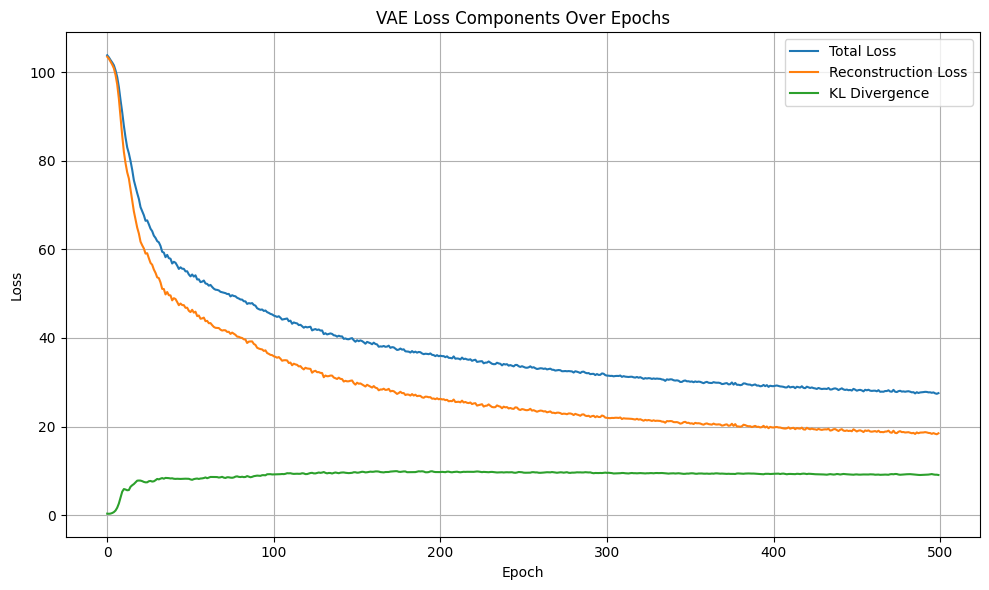

In [5]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


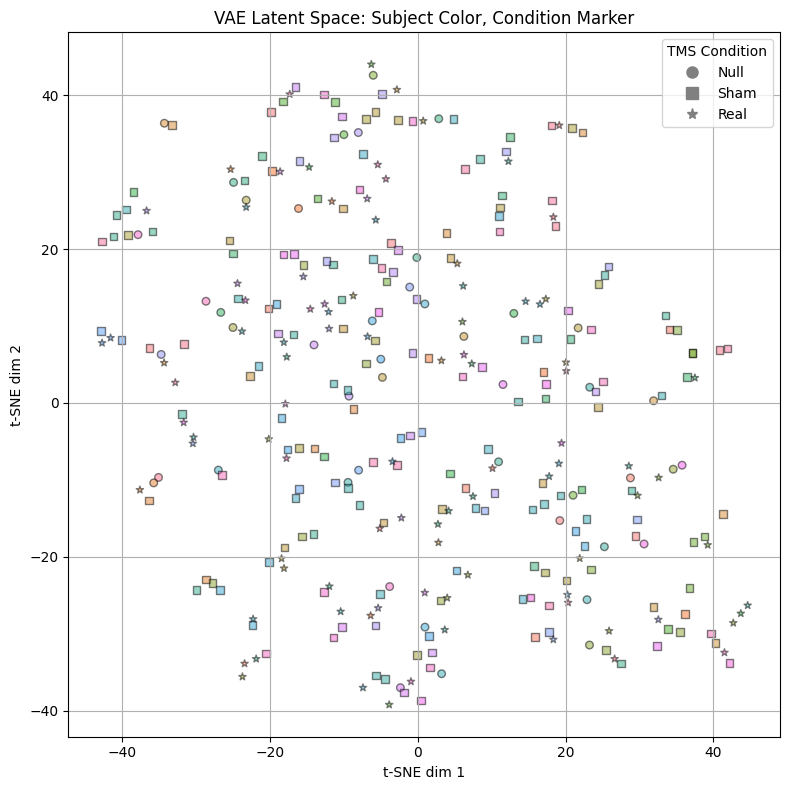

In [7]:
mu_all = get_latent_mu_cvae(model, X_tensor, subject_cond_tensor, device=DEVICE)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -2.546, p = 0.0144


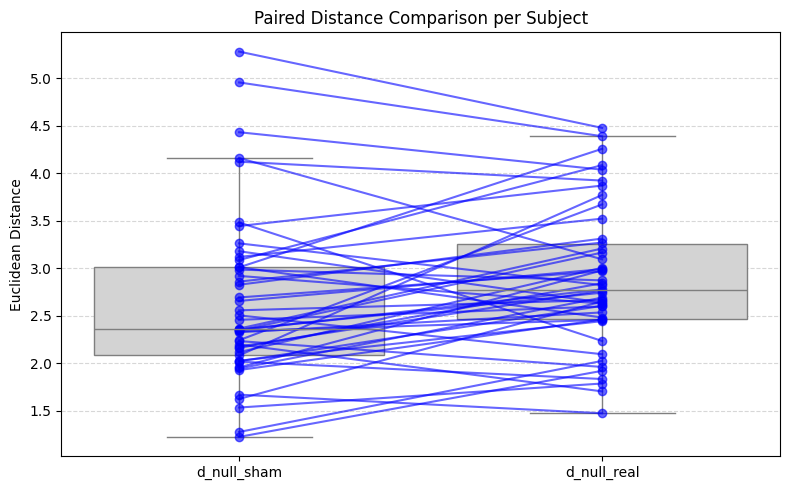

In [8]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)

In [16]:
output_filename = f"../../data_mri_processed/dist_summary_roi_{use_roi}.csv"

# Save DataFrame to CSV
df.to_csv(output_filename, index=False)

In [17]:
df_session_dists = compute_per_session_dist_to_null(mu_all, all_subject_id, all_tms_type, all_session)
df_session_dists.head(10)

output_filename = f"../../data_mri_processed/session_distances_roi_{use_roi}.csv"

# Save to CSV
df_session_dists.to_csv(output_filename, index=False)